# Sampling from a Probabilistic Circuit

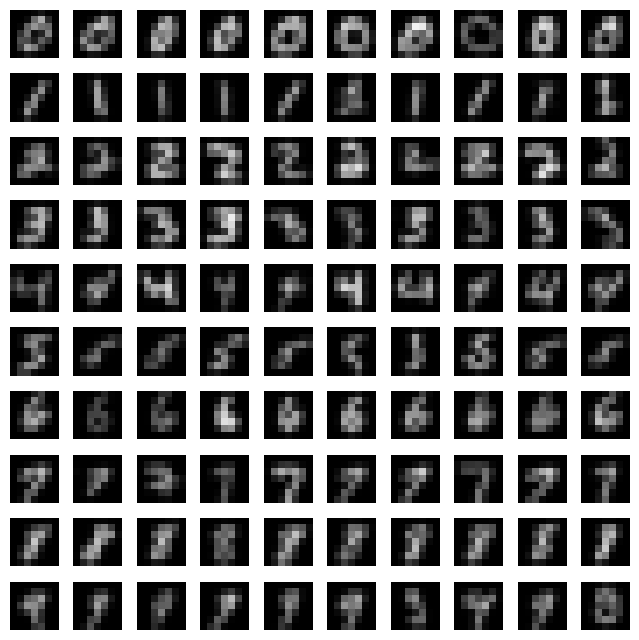

In [1]:
import sys
sys.path.insert(0, "../")

import matplotlib.pyplot as plt

import torch
from torch import optim
from torch.utils.data import DataLoader
from torchvision import transforms, datasets

# Load the MNIST data set and rescale images
transform = transforms.Compose([
    # resize to 5x5
    transforms.Resize((7, 7)),
    transforms.ToTensor(),
    # Flatten the images and set pixel values in the [0-255] range
    transforms.Lambda(lambda x: (255 * x.view(-1)).long())
])
data_train = datasets.MNIST('datasets', train=True, download=True, transform=transform)
data_test = datasets.MNIST('datasets', train=False, download=True, transform=transform)


fig, axs = plt.subplots(10, 10, figsize=(6.5, 6.5))

for i in range(10):
    i_targets = torch.where(data_train.targets == i)[0]

    for j in range(10):
        axs[i, j].imshow(data_train[i_targets[j].item()][0].detach().cpu().numpy().reshape(7, 7), cmap="grey", vmin=0, vmax=255)
        axs[i, j].axis("off")

fig.tight_layout()

We will construct the circuit as a QuadGraph and overparameterize it with $64$ units for each sum and each input.

In [2]:
from cirkit.pipeline import PipelineContext
from cirkit.templates import data_modalities, utils

device = "cuda:0"

# construct the quad graph circuit
symbolic_circuit = data_modalities.image_data(
    (1, 7, 7),                  
    region_graph='quad-graph',  
    input_layer='categorical',  
    num_input_units=64,         
    sum_product_layer='cp',     
    num_sum_units=64,           
    sum_weight_param=utils.Parameterization(activation='softmax', initialization='normal')
)

# compile it as usual
# NOTE: using compiler's optimization is not implemented yet for MAP
ctx = PipelineContext(semiring="lse-sum", fold=True)
circuit = ctx.compile(symbolic_circuit).to(device)

print(f"{(sum(p.numel() for p in circuit.parameters()) / 1e6):.2f}M trainable parameters")

1.54M trainable parameters


As usual, we learn the data by MLE

In [3]:
# Instantiate the training and testing data loaders
train_dataloader = DataLoader(data_train, shuffle=True, batch_size=256)
test_dataloader = DataLoader(data_test, shuffle=False, batch_size=256)

# Initialize a torch optimizer of your choice,
#  e.g., Adam, by passing the parameters of the circuit
optimizer = optim.Adam(circuit.parameters(), lr=0.1)

num_epochs = 10
step_idx = 0
running_loss = 0.0
running_samples = 0

# Move the circuit to chosen device
circuit = circuit.to(device)

for epoch_idx in range(num_epochs):
    for i, (batch, _) in enumerate(train_dataloader):
        # The circuit expects an input of shape (batch_dim, num_variables)
        batch = batch.to(device)

        # Compute the log-likelihoods of the batch, by evaluating the circuit
        log_likelihoods = circuit(batch)

        # We take the negated average log-likelihood as loss
        loss = -1 * torch.mean(log_likelihoods)
        loss.backward()
        # Update the parameters of the circuits, as any other model in PyTorch
        optimizer.step()
        optimizer.zero_grad()
        running_loss += loss.detach() * len(batch)
        running_samples += len(batch)
        step_idx += 1
        
    average_nll = running_loss / running_samples
    print(f"Epoch: {epoch_idx} | Average NLL: {average_nll}")
    running_loss = 0.0
    running_samples = 0

Epoch: 0 | Average NLL: 145.71725463867188
Epoch: 1 | Average NLL: 129.94448852539062
Epoch: 2 | Average NLL: 127.45894622802734
Epoch: 3 | Average NLL: 126.35305786132812
Epoch: 4 | Average NLL: 125.61277770996094
Epoch: 5 | Average NLL: 125.10906219482422
Epoch: 6 | Average NLL: 124.7227783203125
Epoch: 7 | Average NLL: 124.41356658935547
Epoch: 8 | Average NLL: 124.1693115234375
Epoch: 9 | Average NLL: 123.97074890136719


First, let's randomly sample from the circuit.

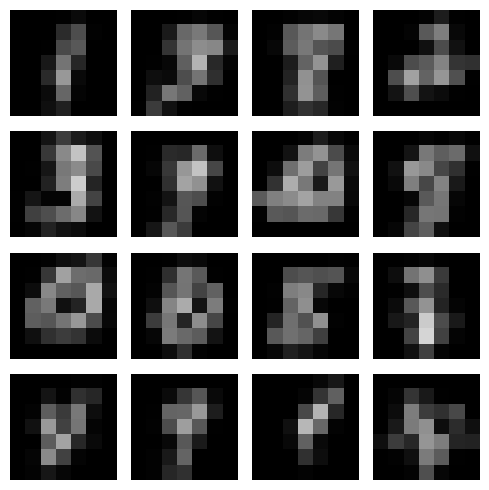

In [41]:
from cirkit.backend.torch.queries import SamplingQuery

# For convenience, move the circuit to cpu during inference
circuit = circuit.to("cpu")

# sample some images
sampling_query = SamplingQuery(circuit)
_, samples = sampling_query(num_samples=16)

fig, axs = plt.subplots(4, 4, figsize=(5, 5))
for sample, ax in zip(samples, axs.flatten()):
    ax.imshow(sample.detach().cpu().numpy().reshape(7, 7), cmap="grey", vmin=0, vmax=255)
    ax.axis("off")

fig.tight_layout()

Let's try to sample variations of the same image by sampling conditionally.

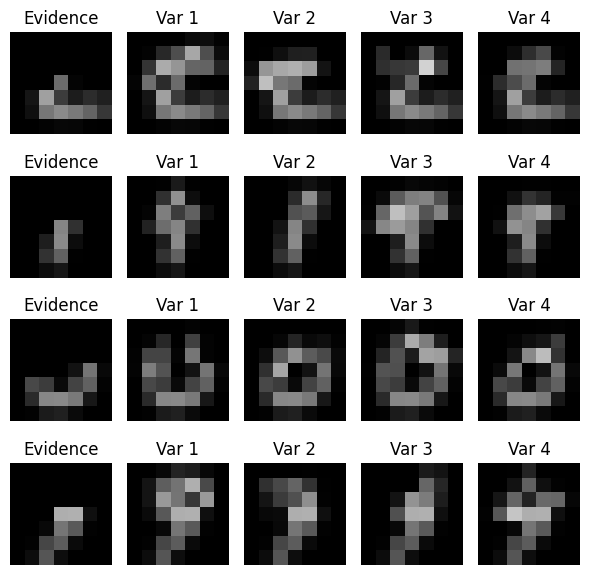

In [56]:
# select the images to erase
sample_idxs = [1, 5, 10, 1000]
fig, axs = plt.subplots(len(sample_idxs), 5, figsize=(6, 1.5 * len(sample_idxs)))
for i, s_idx in enumerate(sample_idxs):
    # take images from the testing set
    sample = data_test[s_idx][0].unsqueeze(0)
    
    # select the variables used as evidence
    evidence_vars = torch.full_like(sample, 0)
    evidence_vars[:, sample.shape[1] // 2:] = 1
    evidence_vars = evidence_vars.bool()
    evidence = sample.clone()
    evidence[~evidence_vars] = 0

    axs[i, 0].set_title("Evidence")
    axs[i, 0].imshow(evidence.detach().cpu().numpy().reshape(7, 7), cmap="grey", vmin=0, vmax=255)
    axs[i, 0].axis("off")

    # compute some image reconstruction
    _, variation = sampling_query(
        num_samples=4,
        x=evidence.to(circuit.device), 
        evidence_vars=evidence_vars.bool().to(circuit.device)
    )

    for j in range(1, 5):
        axs[i, j].set_title(f"Var {j}")
        axs[i, j].imshow(variation[j - 2].detach().cpu().numpy().reshape(7, 7), cmap="grey", vmin=0, vmax=255)
        axs[i, j].axis("off")

fig.tight_layout()